# Определение токсичных комментариев с BERT

## Введение

### Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

### Цель проекта
Разработать решение, которое позволит сервису определять токсичные комментарии. F1-мера на тестовой выборке должна достигать 0.75 или выше.

### План работ:
1. Провести EDA
2. Перевести текст в word embeddings
3. Обучить, протестировать модель МО
4. Оформить выводы

## Загрузка данных и анализ распределения целевого признака

### Загрузка данных

In [1]:
# Библиотеки
#!pip install torch -q
#!pip install tqdm -q
#!pip install torch -q
#!pip install transformers -q
#!pip install catboost -q

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import transformers
from tqdm import notebook

from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, RandomizedSearchCV)
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, AutoModel

# Опционально:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(
    'https://drive.google.com/uc?export=download&id=1gxolXmarN4vm7Wo2Rl14K7v9wBxZCWEr').drop('Unnamed: 0', axis=1)
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Данные соответствуют описанию.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


#### Вывод: 
Данные соответствуют описанию, пропуски отсутствуют, типы данных оптимальны.

## Предобработка данных

Проверим, есть ли в данных дубликаты

In [5]:
data.duplicated().sum()

0

#### Вывод:
- Дубликаты отсутствуют
- Пропуски отсутствуют
- Типы данных оптимальны

### EDA
Проверим, есть ли в данных классовый дисбаланс

In [6]:
def display_imbalance(df):
    df.pivot_table(index='toxic', values='text', aggfunc='count').reset_index().plot(y='text', kind='bar', legend=False)
    plt.title('Распределение классов на имеющихся данных')
    plt.ylabel('Частота класса')
    plt.xlabel('Класс')
    plt.show()

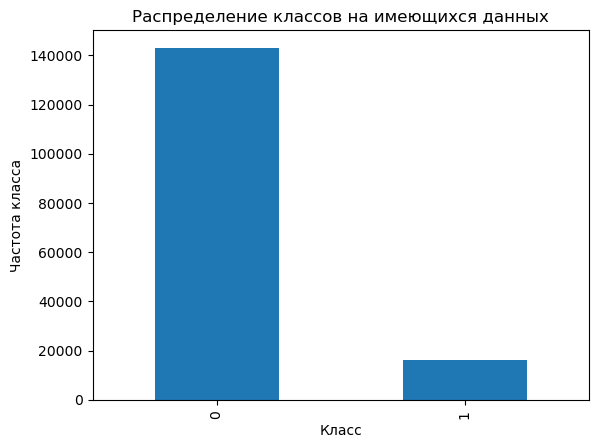

In [7]:
display_imbalance(data)

В данных присутствует сильный классовый дисбаланс - негативно помеченных комментариев в 7 раз меньше, чем позитивных. Необходимо будет это учесть при разделении данных на выборки и обучении моделей.

In [8]:
np.random.seed(42)

# Сократим выборку до 5000 строк, чтобы
# код выполнялся не слишком долго
data = data.sample(5000)

Проверим, сохранилось ли отношение классов

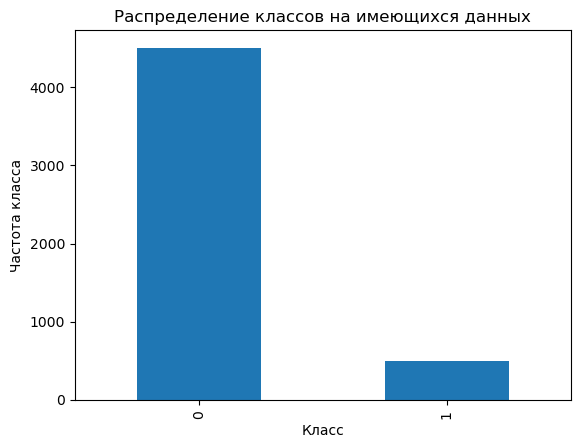

In [9]:
display_imbalance(data)

#### Вывод:
Отношение классов на выборке сохранено. Для устранения последствий классового дисбаланса установим гиперпараметры для регулировки весов классов в моделях.

## Подготовка модели

### Подготовка признаков

Примененим BERT для создания признаков

In [10]:
# Токенизатор
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=50))

# Максимальная длина комментария
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [11]:
# Используем модель BERT
model = AutoModel.from_pretrained("unitary/toxic-bert")

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

# Выделим входные признаки и таргет в отдельные переменные
features = np.concatenate(embeddings)
target = data['toxic']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/50 [00:00<?, ?it/s]

Признаки готовы, можно обучать модель

### Обучение модели

Разделим данные на выборки и обучим модель для предсказания токсичных комментариев

In [12]:
np.random.seed(42)

# Выборки
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.25, stratify=target)

# Пайплайн для обучения
final_pipe = Pipeline(
    [
        ('models', LogisticRegression())
    ]
)

# Список со словарями для подбора гиперпараметров
parameters = [
    {
        'models': [LogisticRegression(class_weight='balanced')],
        'models__C': [0.1, 1, 10]
    }, 
    {
        'models': [CatBoostClassifier(verbose=False, class_weights=[1, 7])],
        'models__max_depth': range(4, 8)
    }
]

searh = RandomizedSearchCV(
    final_pipe,
    parameters,
    cv=5,
    n_jobs=1,
    scoring='f1'
)

# Поиск лучшей модели
searh.fit(train_features, train_target)
estimator = searh.best_estimator_
print(estimator)
print(f'best f1-scoring: {searh.best_score_}')

Pipeline(steps=[('models',
                 <catboost.core.CatBoostClassifier object at 0x32eee67d0>)])
best f1-scoring: 0.8664123267548189


Результат неплохой, можно двигаться дальше.

### Проверка модели на тестовой выборке

In [13]:
print(f'F1-score на тестовой выборке: {f1_score(test_target, estimator.predict(test_features))}')

F1-score на тестовой выборке: 0.9016393442622951


Модель отлично справилась с тестовыми данными!

## Заключение

### Общий вывод
1. Загружены данные, проведена предобработка и исследовательский анализ
2. С помощью BERT созданы признаки, позволяющие обучить модель МО определять токсичные (негативные) комментарии
3. Обучена модель на базе CatBoost, которая позволяет определять токсичные комментарии, при том F1-мера у этой модели 0.87, показатель отличный.

### Рекомендации
Рекомендуем Заказчику использовать модель для классифицирования токсичных комментариев, так как она обладает достаточно высокой метрикой F1.